In [ ]:
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
# !mv ratings_*.txt ~/work/sentiment_classification/data

In [7]:
# !pip install konlpy
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh

fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/home/jovyan/work/workplace/AIFFEL_quest_rs/Exploration/Quest05/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab_light_220429.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-08-02 08:17:50--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.136, 13.200.41.134, 13.200.41.135, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.136|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content-disposition=attachment%3B%20filename%3D%22mecab-0.996-ko-0.9.2.tar.gz%22&response-content-encoding=None&AWSAccessKeyId=ASIA6K

In [2]:
# !python --version

Python 3.12.11


In [1]:
# 의존성 연결을 위해 다운그레이드를 진행합니다.
!pip install scipy==1.12.0 numpy==1.26.3

In [2]:
import pandas as pd
import os

# 데이터를 읽어봅시다.
train_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
# 함수가 정상 작동하는지 확인하기 위한 테스트 코드

# 테스트를 위한 가상의 word_to_index와 index_to_word 딕셔너리를 만듭니다.
# 실제 데이터의 딕셔너리와 구조가 유사해야 합니다.
test_word_to_index = {
    '<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '': 3,
    'hello': 4, 'world': 5, 'python': 6, 'is': 7, 'great': 8
}
test_index_to_word = {index: word for word, index in test_word_to_index.items()}

# 테스트 문장
test_sentence = 'hello world python is great'
test_sentences = ['hello world', 'python is great', 'hello python']

# 1. get_encoded_sentence 테스트
encoded_sentence = get_encoded_sentence(test_sentence, test_word_to_index)
print(f"원본 문장: {test_sentence}")
print(f"인코딩 결과: {encoded_sentence}")
print("-" * 30)

# 2. get_encoded_sentences 테스트
encoded_sentences = get_encoded_sentences(test_sentences, test_word_to_index)
print(f"원본 문장 리스트: {test_sentences}")
print(f"인코딩 결과 리스트: {encoded_sentences}")
print("-" * 30)

# 3. get_decoded_sentence 테스트
decoded_sentence = get_decoded_sentence(encoded_sentence, test_index_to_word)
print(f"인코딩된 문장: {encoded_sentence}")
print(f"디코딩 결과: {decoded_sentence}")
print("-" * 30)

# 4. get_decoded_sentences 테스트
decoded_sentences = get_decoded_sentences(encoded_sentences, test_index_to_word)
print(f"인코딩된 문장 리스트: {encoded_sentences}")
print(f"디코딩 결과 리스트: {decoded_sentences}")

원본 문장: hello world python is great
인코딩 결과: [1, 4, 5, 6, 7, 8]
------------------------------
원본 문장 리스트: ['hello world', 'python is great', 'hello python']
인코딩 결과 리스트: [[1, 4, 5], [1, 6, 7, 8], [1, 4, 6]]
------------------------------
인코딩된 문장: [1, 4, 5, 6, 7, 8]
디코딩 결과: hello world python is great
------------------------------
인코딩된 문장 리스트: [[1, 4, 5], [1, 6, 7, 8], [1, 4, 6]]
디코딩 결과 리스트: ['hello world', 'python is great', 'hello python']


In [ ]:
# 3) 모델 구성을 위한 데이터 분석 및 가공

In [7]:
 #데이터셋 내 문장 길이 분포
 #적절한 최대 문장 길이 지정


total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(
    f'전체 문장의 
    {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 
    maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
# 문장 길이 통일(패딩추가) 및 텐서 변환
import torch  # 딥러닝 프레임워크 PyTorch 라이브러리

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            # 문장 길이가 maxlen보다 짧으면, 0(패딩)을 추가하여 길이 맞추기
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            # 문장 길이가 maxlen보다 길면, 뒷부분을 잘라서 길이 맞추기
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)  # 결과를 numpy 배열로 반환

X_train_padded = pad_sequences(X_train, maxlen)  # 훈련 데이터의 길이를 maxlen에 맞춤
X_test_padded = pad_sequences(X_test, maxlen)  # 테스트 데이터의 길이를 maxlen에 맞춤

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)  # 패딩된 훈련 데이터를 PyTorch 텐서로 변환
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)  # 패딩된 테스트 데이터를 PyTorch 텐서로 변환

print(X_train_tensor.shape)  # 변환된 훈련 텐서의 형태(shape) 출력

torch.Size([146182, 41])


In [ ]:
# 4)모델 구성 및 validation set 구성

In [10]:
# LSTM 기반 감성 분석 모델 정의 및 구조 출력
import torch  # 딥러닝 프레임워크 PyTorch 라이브러리
import torch.nn as nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 함수 모음

vocab_size = 10000  # 모델이 다룰 수 있는 단어의 총 개수
word_vector_dim = 16  # 각 단어를 표현하는 워드 벡터의 차원

# 모델 설계: nn.Module을 상속받아 SentimentModel 클래스 정의
class SentimentModel(nn.Module):
    # 모델의 레이어(Layer)들을 정의
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()  # nn.Module의 생성자 호출
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)  # 단어를 워드 벡터로 변환하는 임베딩 레이어
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)  # 워드 벡터 시퀀스를 처리하는 LSTM 레이어
        self.fc1 = nn.Linear(8, 8)  # LSTM의 최종 출력을 받아서 처리하는 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(8, 1)  # 최종 출력을 0과 1 사이의 값으로 만드는 두 번째 완전 연결 레이어

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, x):
        x = self.embedding(x)  # 입력(단어 인덱스)을 임베딩 레이어에 통과시켜 워드 벡터로 변환
        x, (hn, cn) = self.lstm(x)  # 임베딩 벡터 시퀀스를 LSTM에 통과
        x = x[:, -1, :]  # LSTM의 최종 시점(sequence의 마지막)의 은닉 상태를 가져옴
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 레이어에 통과시키고 ReLU 활성화 함수 적용
        x = torch.sigmoid(self.fc2(x))  # 두 번째 완전 연결 레이어에 통과시키고 시그모이드 활성화 함수 적용 (0~1 사이 값)
        return x  # 최종 출력값 반환

model = SentimentModel(vocab_size, word_vector_dim)  # 정의된 클래스를 바탕으로 모델 객체 생성
print(model)  # 모델의 레이어 구조와 파라미터 정보 출력

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [11]:
# validation set 10000건 분리
X_val = X_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

torch.Size([136182, 41])
(136182,)


In [ ]:
# 5) 모델 훈련 개

In [12]:
# PyTorch를 이용한 감성 분석 모델 훈련
import torch.optim as optim  # 최적화 도구 모음
import torch.nn.functional as F  # 활성화 함수, 손실 함수 등
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티

optimizer = optim.Adam(model.parameters())  # 모델의 파라미터를 업데이트할 Adam 최적화 도구 설정
loss_fn = torch.nn.BCELoss()  # 이진 분류에 적합한 Binary Cross Entropy 손실 함수 설정

partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)  # 훈련용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)  # 훈련용 라벨 데이터를 PyTorch 텐서로 변환 (BCELoss를 위해 float 타입 사용)

X_val_tensor = X_val.detach().clone().to(torch.long)  # 검증용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
y_val_tensor = torch.tensor(y_val, dtype=torch.float)  # 검증용 라벨 데이터를 PyTorch 텐서로 변환

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)  # 훈련 데이터와 라벨을 묶어 데이터셋 생성
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)  # 검증 데이터와 라벨을 묶어 데이터셋 생성

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # 훈련용 데이터로더 생성 (배치 크기 512, 데이터 섞기)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)  # 검증용 데이터로더 생성 (배치 크기 512, 데이터 섞지 않음)

epochs = 30  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []  # 에포크별 검증 손실을 저장할 리스트
train_accs = []  # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []  # 에포크별 검증 정확도를 저장할 리스트

for epoch in range(epochs):
    # 훈련 단계 시작
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0  # 현재 에포크의 누적 손실 초기화
    correct = 0  # 현재 에포크의 정답 수 초기화
    total = 0  # 현재 에포크의 전체 데이터 수 초기화

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화

        outputs = model(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()  # 현재 배치 손실을 누적
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
        total += labels.size(0)  # 전체 데이터 수 누적

    train_losses.append(running_loss / len(train_loader))  # 에포크별 평균 훈련 손실 기록
    train_accs.append(correct / total)  # 에포크별 훈련 정확도 기록

    # 검증 단계 시작
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0  # 현재 에포크의 누적 검증 손실 초기화
    val_correct = 0  # 현재 에포크의 정답 수 초기화
    val_total = 0  # 현재 에포크의 전체 데이터 수 초기화

    with torch.no_grad():  # 기울기 계산을 비활성화 (메모리 절약, 연산 속도 향상)
        for inputs, labels in val_loader:
            outputs = model(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
            loss = loss_fn(outputs.squeeze(), labels)  # 손실 계산

            val_loss += loss.item()  # 현재 배치 손실을 누적
            predicted = (outputs.squeeze() > 0.5).float()  # 예측값 기반으로 정답 판단
            val_correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
            val_total += labels.size(0)  # 전체 데이터 수 누적

    val_losses.append(val_loss / len(val_loader))  # 에포크별 평균 검증 손실 기록
    val_accs.append(val_correct / val_total)  # 에포크별 검증 정확도 기록

    # 에포크별 결과 출력
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

Epoch 1/30 - Train Loss: 0.6930, Train Accuracy: 0.5028 - Validation Loss: 0.6926, Validation Accuracy: 0.5078
Epoch 2/30 - Train Loss: 0.6927, Train Accuracy: 0.5052 - Validation Loss: 0.6926, Validation Accuracy: 0.5072
Epoch 3/30 - Train Loss: 0.6924, Train Accuracy: 0.5052 - Validation Loss: 0.6922, Validation Accuracy: 0.5093
Epoch 4/30 - Train Loss: 0.6307, Train Accuracy: 0.6219 - Validation Loss: 0.5184, Validation Accuracy: 0.7512
Epoch 5/30 - Train Loss: 0.4600, Train Accuracy: 0.7872 - Validation Loss: 0.4277, Validation Accuracy: 0.8063
Epoch 6/30 - Train Loss: 0.4005, Train Accuracy: 0.8220 - Validation Loss: 0.3983, Validation Accuracy: 0.8203
Epoch 7/30 - Train Loss: 0.3719, Train Accuracy: 0.8369 - Validation Loss: 0.3796, Validation Accuracy: 0.8289
Epoch 8/30 - Train Loss: 0.3527, Train Accuracy: 0.8474 - Validation Loss: 0.3709, Validation Accuracy: 0.8327
Epoch 9/30 - Train Loss: 0.3404, Train Accuracy: 0.8535 - Validation Loss: 0.3647, Validation Accuracy: 0.8360
E

In [13]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3865, Test Accuracy: 0.8441


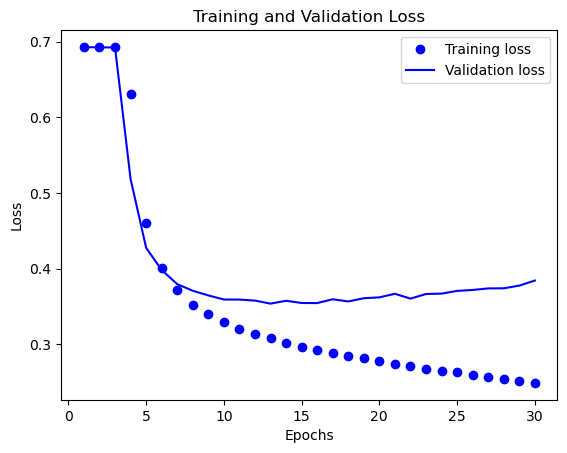

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

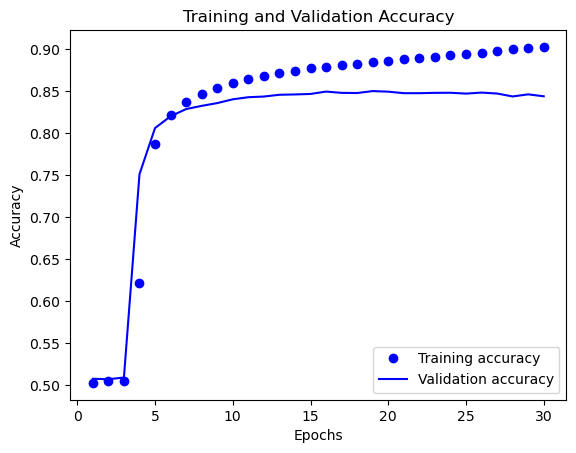

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
8) 한국어 Word2vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]

In [ ]:
# !mkdir -p sentiment_classification/data
# !pip install gensim==4.3.2
# !pip install scipy==1.12.0 numpy==1.26.3

In [ ]:
# embedding_layer = model.embedding
# weights = embedding_layer.weight.detach().cpu().numpy()

# print(weights.shape)  # shape: (vocab_size, embedding_dim)


#!mkdir ~/work/sentiment_classification/word2vec_emb

In [17]:
import os
from gensim.models import Word2Vec

# 경로를 환경 변수와 결합하여 전체 경로를 만듭니다.
word2vec_file_path = os.path.join(os.getenv('HOME'), 'work/sentiment_classification/data/word2vec_ko.model')

# load() 함수를 사용하여 한국어 Word2Vec 모델 불러오기
try:
    word2vec_ko = Word2Vec.load(word2vec_file_path)
    print("한국어 Word2Vec 모델을 성공적으로 로드했습니다.")

    # .wv를 붙여서 활용
    vector = word2vec_ko.wv['사랑']
    print(f"'사랑' 단어의 벡터 차원: {vector.shape}")
    print(f"'사랑'과 유사한 단어: {word2vec_ko.wv.similar_by_word('사랑')}")

except FileNotFoundError:
    print(f"오류: {word2vec_file_path} 경로에 파일이 존재하지 않습니다.")
except Exception as e:
    print(f"모델 로드 중 오류가 발생했습니다: {e}")
# 전체 워드 벡터의 차원 확인
print(f"전체 워드 벡터의 shape: {word2vec_ko.wv.vectors.shape}")

한국어 Word2Vec 모델을 성공적으로 로드했습니다.
'사랑' 단어의 벡터 차원: (100,)
'사랑'과 유사한 단어: [('이별', 0.7626414895057678), ('행복', 0.7550068497657776), ('슬픔', 0.7381505966186523), ('유혹', 0.7238055467605591), ('그리움', 0.7167419195175171), ('추억', 0.7143999338150024), ('꿈', 0.7089294195175171), ('애정', 0.7066588997840881), ('포옹', 0.7034594416618347), ('마음', 0.6972615718841553)]
전체 워드 벡터의 shape: (302960, 100)


In [20]:
# Word2Vec 모델의 워드 벡터를 embedding_matrix에 복사
vocab_size = 10000  # 모델이 사용할 총 단어의 개수
word_vector_dim = 100  # 워드 벡터의 차원 (Word2Vec 모델과 동일하게 300으로 설정)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)  # 임의의 값으로 초기화된 임베딩 행렬 생성

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):  # 단어 인덱스 4부터 시작하여 모든 단어에 대해 반복
    if index_to_word[i] in word2vec_ko.wv:  # 현재 단어가 Word2Vec 모델에 포함되어 있는지 확인
        embedding_matrix[i] = word2vec_ko.wv[index_to_word[i]]  # 포함되어 있다면, 해당 단어의 워드 벡터를 embedding_matrix의 i번째 행에 복사

In [21]:
# LSTM 기반 감성 분석 모델 정의 및 구조 출력
import torch  # 딥러닝 프레임워크 PyTorch 라이브러리
import torch.nn as nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 함수 모음

vocab_size = 10000  # 모델이 다룰 수 있는 단어의 총 개수
word_vector_dim = 100  # 각 단어를 표현하는 워드 벡터의 차원

# 모델 설계: nn.Module을 상속받아 SentimentModel 클래스 정의
class SentimentModel(nn.Module):
    # 모델의 레이어(Layer)들을 정의
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()  # nn.Module의 생성자 호출
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)  # 단어를 워드 벡터로 변환하는 임베딩 레이어
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)  # 워드 벡터 시퀀스를 처리하는 LSTM 레이어
        self.fc1 = nn.Linear(8, 8)  # LSTM의 최종 출력을 받아서 처리하는 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(8, 1)  # 최종 출력을 0과 1 사이의 값으로 만드는 두 번째 완전 연결 레이어

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, x):
        x = self.embedding(x)  # 입력(단어 인덱스)을 임베딩 레이어에 통과시켜 워드 벡터로 변환
        x, (hn, cn) = self.lstm(x)  # 임베딩 벡터 시퀀스를 LSTM에 통과
        x = x[:, -1, :]  # LSTM의 최종 시점(sequence의 마지막)의 은닉 상태를 가져옴
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 레이어에 통과시키고 ReLU 활성화 함수 적용
        x = torch.sigmoid(self.fc2(x))  # 두 번째 완전 연결 레이어에 통과시키고 시그모이드 활성화 함수 적용 (0~1 사이 값)
        return x  # 최종 출력값 반환

model = SentimentModel(vocab_size, word_vector_dim)  # 정의된 클래스를 바탕으로 모델 객체 생성
print(model)  # 모델의 레이어 구조와 파라미터 정보 출력

SentimentModel(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [22]:
# PyTorch를 이용한 감성 분석 모델 훈련
import torch.optim as optim  # 최적화 도구 모음
import torch.nn.functional as F  # 활성화 함수, 손실 함수 등
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티

#모델 임베딩 초기화로 Word2vec 임베딩 매트릭스 적용
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))


optimizer = optim.Adam(model.parameters())  # 모델의 파라미터를 업데이트할 Adam 최적화 도구 설정
loss_fn = torch.nn.BCELoss()  # 이진 분류에 적합한 Binary Cross Entropy 손실 함수 설정

partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)  # 훈련용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)  # 훈련용 라벨 데이터를 PyTorch 텐서로 변환 (BCELoss를 위해 float 타입 사용)

X_val_tensor = X_val.detach().clone().to(torch.long)  # 검증용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
y_val_tensor = torch.tensor(y_val, dtype=torch.float)  # 검증용 라벨 데이터를 PyTorch 텐서로 변환

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)  # 훈련 데이터와 라벨을 묶어 데이터셋 생성
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)  # 검증 데이터와 라벨을 묶어 데이터셋 생성

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # 훈련용 데이터로더 생성 (배치 크기 512, 데이터 섞기)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)  # 검증용 데이터로더 생성 (배치 크기 512, 데이터 섞지 않음)

epochs = 30  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []  # 에포크별 검증 손실을 저장할 리스트
train_accs = []  # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []  # 에포크별 검증 정확도를 저장할 리스트

for epoch in range(epochs):
    # 훈련 단계 시작
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0  # 현재 에포크의 누적 손실 초기화
    correct = 0  # 현재 에포크의 정답 수 초기화
    total = 0  # 현재 에포크의 전체 데이터 수 초기화

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화

        outputs = model(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()  # 현재 배치 손실을 누적
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
        total += labels.size(0)  # 전체 데이터 수 누적

    train_losses.append(running_loss / len(train_loader))  # 에포크별 평균 훈련 손실 기록
    train_accs.append(correct / total)  # 에포크별 훈련 정확도 기록

    # 검증 단계 시작
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0  # 현재 에포크의 누적 검증 손실 초기화
    val_correct = 0  # 현재 에포크의 정답 수 초기화
    val_total = 0  # 현재 에포크의 전체 데이터 수 초기화

    with torch.no_grad():  # 기울기 계산을 비활성화 (메모리 절약, 연산 속도 향상)
        for inputs, labels in val_loader:
            outputs = model(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
            loss = loss_fn(outputs.squeeze(), labels)  # 손실 계산

            val_loss += loss.item()  # 현재 배치 손실을 누적
            predicted = (outputs.squeeze() > 0.5).float()  # 예측값 기반으로 정답 판단
            val_correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
            val_total += labels.size(0)  # 전체 데이터 수 누적

    val_losses.append(val_loss / len(val_loader))  # 에포크별 평균 검증 손실 기록
    val_accs.append(val_correct / val_total)  # 에포크별 검증 정확도 기록

    # 에포크별 결과 출력
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

Epoch 1/30 - Train Loss: 0.6545, Train Accuracy: 0.6025 - Validation Loss: 0.5726, Validation Accuracy: 0.7096
Epoch 2/30 - Train Loss: 0.5037, Train Accuracy: 0.7641 - Validation Loss: 0.4660, Validation Accuracy: 0.7862
Epoch 3/30 - Train Loss: 0.4251, Train Accuracy: 0.8132 - Validation Loss: 0.4263, Validation Accuracy: 0.8092
Epoch 4/30 - Train Loss: 0.3859, Train Accuracy: 0.8352 - Validation Loss: 0.4033, Validation Accuracy: 0.8232
Epoch 5/30 - Train Loss: 0.3616, Train Accuracy: 0.8484 - Validation Loss: 0.3975, Validation Accuracy: 0.8269
Epoch 6/30 - Train Loss: 0.3451, Train Accuracy: 0.8574 - Validation Loss: 0.3931, Validation Accuracy: 0.8288
Epoch 7/30 - Train Loss: 0.3309, Train Accuracy: 0.8651 - Validation Loss: 0.3892, Validation Accuracy: 0.8334
Epoch 8/30 - Train Loss: 0.3199, Train Accuracy: 0.8704 - Validation Loss: 0.3921, Validation Accuracy: 0.8348
Epoch 9/30 - Train Loss: 0.3099, Train Accuracy: 0.8758 - Validation Loss: 0.3923, Validation Accuracy: 0.8342
E

In [23]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.4551, Test Accuracy: 0.8319


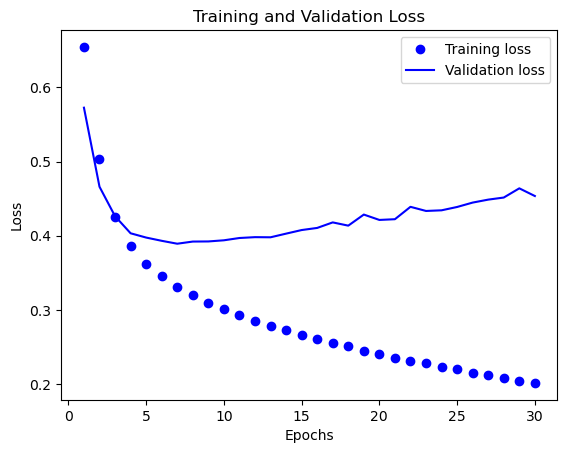

In [24]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

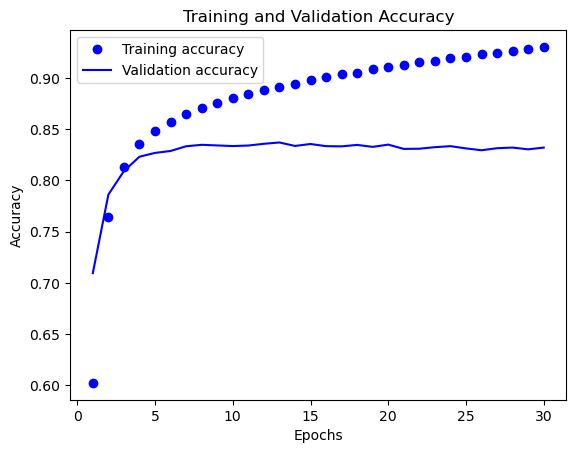

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()